# This code plots the cross-correlation obtained in data simulations, and compares it to the theoretical expectation

### - import libraries

In [1]:
# Global imports
import sys
import tqdm
import numpy as np
import jax
import jax.numpy as jnp
from scipy.special import legendre
import matplotlib.pyplot as plt

sys.path.append("../")

# Local imports
import examples_utils as eu
from fastPTA import utils as ut
from fastPTA import get_tensors as gt
from fastPTA.data import generate_data as gd
from fastPTA.angular_decomposition import spherical_harmonics as sph
from fastPTA.data import data_correlations as dc

print(eu.path_to_file)
%reload_ext autoreload
%autoreload 2
jax.config.update("jax_enable_x64", True)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 14,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

/home/pieroni/my_projects/fastPTA_papers/paper_cosmic_variance/fastpta_anisotropies/examples/examples_paper_cosmic_variance/..


### - Some utilities we will use later on

In [ ]:
# Function to compute the Hellings–Downs coefficient a_l for a given multipole l
def al(l):
    if l >= 2:
        val = 3 * (2 * l + 1) / (2 * (l + 2) * (l + 1) * l * (l - 1))
    else:
        # a_l is zero for monopole and dipole (l < 2)
        val = 0
    return val


# Compute Hellings–Downs curve for a given set of a_l coefficients and angular separation zeta
def HD_from_a(list_a, zeta):
    # Sum over l of a_l * Legendre polynomial P_l(cos(zeta))
    return np.sum(
        legendre(i)(np.cos(zeta)) * list_a[i] for i in range(len(list_a))
    )


# Generate a random realization of a_l coefficients up to given order
def random_realize_al(order):
    # Compute standard deviation for each a_l (used for random sampling)
    list_al_std = [al(l) / np.sqrt(2 * l + 1) for l in range(order + 1)]

    # Sample each a_l from a Gaussian centered at its theoretical value
    a_l = np.array(
        [np.random.normal(al(l), list_al_std[l]) for l in range(order + 1)]
    )

    return a_l

### - Compute the theoretical HD cosmic variance

In [3]:
# Number of points to evaluate HD curve for plotting
integration_points_HDplot = 10000

# Create array of cos(theta) values evenly spaced in [-1, 1]
x_HDplot = jnp.linspace(-1, 1, integration_points_HDplot)

# Number of random realizations to generate for visualization
len_HD_al = 200

# Generate multiple HD curves with random realizations of a_l
list_vecs = [
    HD_from_a(random_realize_al(15), np.arccos(x_HDplot))
    for i in range(len_HD_al)
]

# Compute the 16th, 50th, and 84th percentiles (±1σ) across all realizations
quantiles_HDplot = np.quantile(
    list_vecs, [(1 - 0.68) / 2, 0.5, (1 + 0.68) / 2], axis=0
)

/tmp/ipykernel_139505/1440017172.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(


### - Plot it

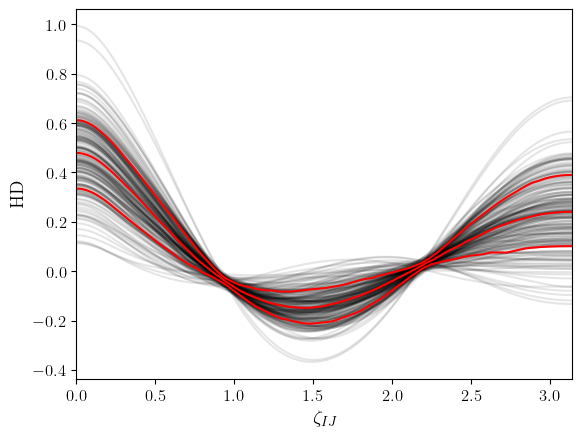

In [4]:
# Plot all individual HD curves with low opacity (alpha=0.1) in black
for i in range(len_HD_al):
    plt.plot(np.arccos(x_HDplot), list_vecs[i], alpha=0.1, color="black")

# Plot the median and ±1σ curves in red
plt.plot(np.arccos(x_HDplot), quantiles_HDplot[0], alpha=1, color="red")
plt.plot(np.arccos(x_HDplot), quantiles_HDplot[1], alpha=1, color="red")
plt.plot(np.arccos(x_HDplot), quantiles_HDplot[2], alpha=1, color="red")

# Label x- and y-axes
plt.xlabel(r"$\zeta_{IJ}$")  # angular separation between pulsars
plt.ylabel(r"${\rm HD}$")  # Hellings–Downs correlation

# Set x-axis limits from 0 to pi (radians)
plt.xlim(0, np.pi)

### - define constants

In [ ]:
# Total observation time in years
Tspan_yrs = 16.0

# Total observation time in seconds
Tspan = Tspan_yrs * ut.yr

# Number of pulsars in the array
npulsars = 200

### - Set frequency vectors and spectra

In [6]:
# Number of frequency bins
nfreqs = 2

# Frequency step for generating ff array
df_step = 0.1

# Starting frequency index for ff array
f_in = 0.5

# Frequency array sampled with df_step, scaled by Tspan
ff = jnp.arange(f_in, nfreqs + 1, step=df_step) / Tspan

# Frequency array sampled at integer multiples of 1/Tspan
fi = jnp.arange(1, nfreqs + 1) / Tspan

# Power spectral density at frequencies ff (power-law f^-7/3)
S_ff = (ff / ut.f_yr) ** -7.0 / 3.0

# Power spectral density at frequencies fi (power-law f^-7/3)
S_fi = (fi / ut.f_yr) ** -7.0 / 3.0

### - Specify the angular structure

In [7]:
# Maximum spherical harmonic multipole
l_max = 3

# HEALPix resolution parameter
Nside = 8

# Initialize spherical harmonic coefficients to zero
clms_real = np.zeros(sph.get_n_coefficients_real(l_max))

# Add the monopole term
clms_real[0] = 1 / np.sqrt(4 * np.pi)

### - Get the spectrum and data normalization

In [8]:
# Generate HEALPix map from spherical harmonic coefficients
Pk = sph.get_map_from_real_clms(clms_real, Nside, l_max=l_max)

# Frequency-dependent power distribution across sky
H_p_ff = Pk[:, None] * S_ff[None, :]

# Compute frequency-domain normalization matrix for D_IJ
C_ff = dc.get_D_IJ_fifj_normalization(Tspan, fi, ff, H_p_ff)

# Compute inverse of C_ff for normalization purposes
inv_ff = ut.compute_inverse(C_ff)

### - Generate the data

In [ ]:
# Generate angular separation and data correlation matrix
_, zeta_IJ, D_IJ_ij = gd.generate_D_IJ_fifj(Nside, npulsars, Tspan, fi, ff, H_p_ff)

# Normalize D_IJ by multiplying with inverse of C_ff along frequency indices
C_normed = jnp.einsum("fg,glab->flab", inv_ff, D_IJ_ij)

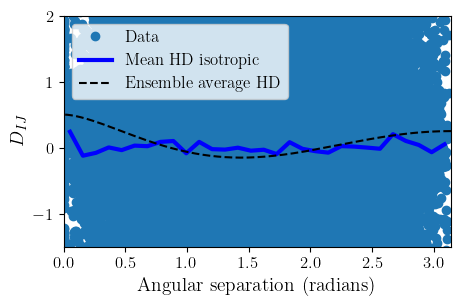

In [ ]:
# Select pulsar pair indices to plot
i = 0
j = 0

# Create a new figure with custom size
plt.figure(figsize=(5, 3))

# Scatter plot of normalized D_IJ for the chosen pulsar pair vs angular separation
plt.plot(
    zeta_IJ.flatten(),
    C_normed[i, j].flatten(),
    "o",
    label="Data",
)

# Compute binned mean and standard deviation of D_IJ as function of angular separation
y, dy, x = ut.compute_D_IJ_mean(
    zeta_IJ.flatten(), C_normed[i, j].flatten(), 30
)

# Plot the binned mean D_IJ (smoothed estimate) vs angular separation
plt.plot(
    x,  # Bin centers
    y,  # Mean D_IJ in each bin
    "blue",
    linewidth=3,
    label="Mean HD isotropic",
)

# Plot the theoretical Hellings–Downs curve for comparison
plt.plot(
    np.arccos(gt.x),  # Convert cosine values to angles
    gt.HD_correlations(gt.x),  # Ensemble average HD correlation
    "black",
    linestyle="dashed",
    label="Ensemble average HD",
)

# Set x-axis limits: 0 to π radians
plt.xlim(0, np.pi)

# Set y-axis limits
plt.ylim(-1.5, 2)

# Label axes
plt.xlabel("Angular separation (radians)")
plt.ylabel("$D_{IJ}$")

# (Optional) Show legend
plt.legend()

### - Data simulation: generate many realizations of the pulsar pulsar correlation matrix and normalize it

In [ ]:
# Number of independent realizations of the pulsar array
n_realizations = 100

# Number of bins for computing binned mean correlations
n_bins = 30

# Lists to store binned results for all realizations
all_binned_y = []
all_binned_x = []

# Loop over realizations with progress bar
for realization in tqdm.tqdm(range(n_realizations)):

    # Generate angular separation and data correlation matrix
    _, zeta_IJ, D_IJ_ij = gd.generate_D_IJ_fifj(
        Nside, npulsars, Tspan, fi, ff, H_p_ff
    )

    # Normalize D_IJ by multiplying with inverse of C_ff along frequency indices
    C_normed = jnp.einsum("fg,glab->flab", inv_ff, D_IJ_ij)

    # Dictionaries to store binned results for this realization
    realization_binned_y = {}
    realization_binned_x = {}

    # Loop over all frequency pairs
    for i in range(len(fi)):
        for j in range(len(fi)):
            # Compute binned mean of D_IJ vs angular separation
            y, dy, x = ut.compute_D_IJ_mean(
                zeta_IJ.flatten(), (C_normed[i, j]).flatten(), n_bins
            )
            # Store results keyed by frequency pair
            realization_binned_y[(i, j)] = y
            realization_binned_x[(i, j)] = x

    # Append this realization's binned results to the overall list
    all_binned_y.append(realization_binned_y)
    all_binned_x.append(realization_binned_x)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


### - Plot the output

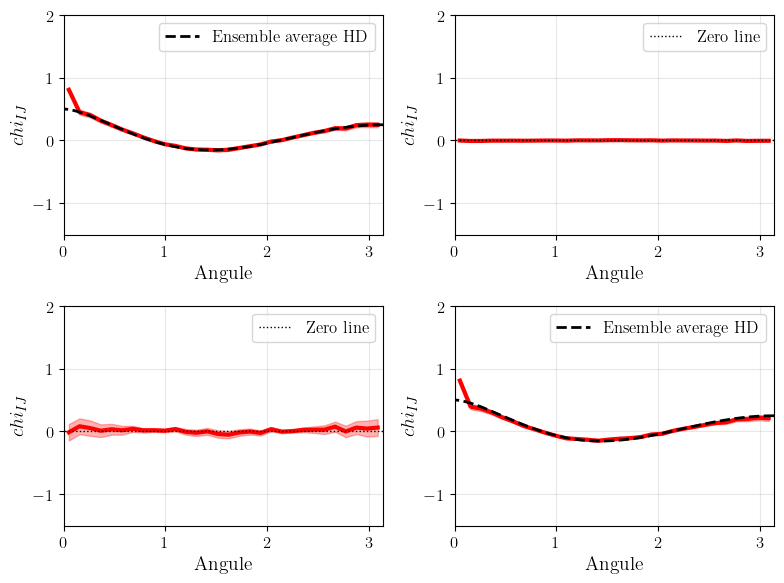

In [ ]:
Nf_plot = len(fi)
fig, axes = plt.subplots(Nf_plot, Nf_plot, figsize=(4 * Nf_plot, 3 * Nf_plot))

# Handle case where Nf = 1 (axes won't be 2D array)
if Nf_plot == 1:
    axes = np.array([[axes]])
elif Nf_plot == 2:
    axes = axes.reshape(Nf_plot, Nf_plot)

for i in range(Nf_plot):
    for j in range(Nf_plot):
        ax = axes[i, j]

        # Extract binned results for this frequency pair across all realizations
        binned_y_this_freq = [real_dict[(i, j)] for real_dict in all_binned_y]
        binned_x_this_freq = [real_dict[(i, j)] for real_dict in all_binned_x]

        # Convert to arrays for easier manipulation
        binned_y_array = np.array(
            binned_y_this_freq
        )  # Shape: (n_realizations, n_bins)
        binned_x_array = np.array(
            binned_x_this_freq
        )  # Shape: (n_realizations, n_bins)

        # Compute average and standard error across realizations
        mean_y = np.mean(binned_y_array, axis=0)
        std_y = np.std(binned_y_array, axis=0)
        sem_y = std_y / np.sqrt(n_realizations)  # Standard error of the mean

        # Use the x values from the first realization (they should be the same)
        mean_x = np.mean(binned_x_array, axis=0)

        # Plot the average binned correlation vs angular separation
        ax.plot(
            mean_x,  # Bin centers of angular separation
            mean_y,  # Mean D_IJ values in each bin
            "red",
            linewidth=3,
        )

        # Shade ±1 standard error around the mean to visualize uncertainty
        ax.fill_between(
            mean_x,  # x-axis values (angular separation)
            mean_y - sem_y,  # Lower bound of standard error
            mean_y + sem_y,  # Upper bound of standard error
            alpha=0.3,
            color="red",
        )

        # If plotting diagonal subplot (same frequency pair)
        if i == j:
            # Overlay the theoretical Hellings–Downs curve
            ax.plot(
                np.arccos(gt.x),  # Convert cos(theta) to angular separation
                gt.HD_correlations(gt.x),  # Theoretical HD correlation
                "black",
                linestyle="dashed",
                linewidth=2,
                label="Ensemble average HD",
            )
        else:
            # For off-diagonal subplots (different frequency pairs), plot zero reference line
            ax.plot(
                np.arccos(gt.x),  # x-axis: angular separation
                gt.x * 0,  # y-axis: zero line
                "black",
                linestyle="dotted",
                linewidth=1,
                label="Zero line",
            )

        # Set x-axis limits from 0 to π radians
        ax.set_xlim(0, np.pi)

        # Set y-axis limits to cover expected D_IJ values
        ax.set_ylim(-1.5, 2)

        # Label x-axis
        ax.set_xlabel("Angule")  # Typo in label: probably meant "Angle"

        # Label y-axis
        ax.set_ylabel(
            r"$chi_{IJ}$"
        )  # Correlation coefficient between pulsar pair

        # Show legend in subplot
        ax.legend()

        # Enable grid with low opacity
        ax.grid(True, alpha=0.3)

# Adjust layout to prevent overlapping subplots
plt.tight_layout()

# Display the figure
plt.show()

### - Data simulations to show mean and total variance

In [13]:
# Number of pulsars to simulate
Np = 100

# Number of independent realizations
n_realizations = 100

# Lists to store averaged results across pulsars and all realizations
x_pulsar_average = []
y_pulsar_average = []
x_all = []  # To store angular separations for all realizations
y_all = []  # To store diagonal of normalized correlations for all realizations

# Loop over realizations with progress bar
for realization in tqdm.tqdm(range(n_realizations)):

    # Generate angular separation and data correlation matrix
    _, zeta_IJ, D_IJ_ij = gd.generate_D_IJ_fifj(
        Nside, npulsars, Tspan, fi, ff, H_p_ff
    )

    # Normalize D_IJ by multiplying with inverse of C_ff along frequency indices
    C_normed = jnp.einsum("fg,glab->flab", inv_ff, D_IJ_ij)

    # Extract the diagonal (same-frequency correlations) and average over pulsars
    C_diag = jnp.mean(
        jnp.array([C_normed[i, i, :, :] for i in range(C_normed.shape[0])]),
        axis=0,
    )

    # Store angular separations and corresponding normalized diagonal correlations
    x_all.append(zeta_IJ)
    y_all.append(C_diag)

# Convert lists to arrays for further analysis
x_all = jnp.array(x_all)  # Shape: (n_realizations, Np, Np)
y_all = jnp.array(y_all)  # Shape: (n_realizations, nfreqs, nfreqs)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


### - Plot it

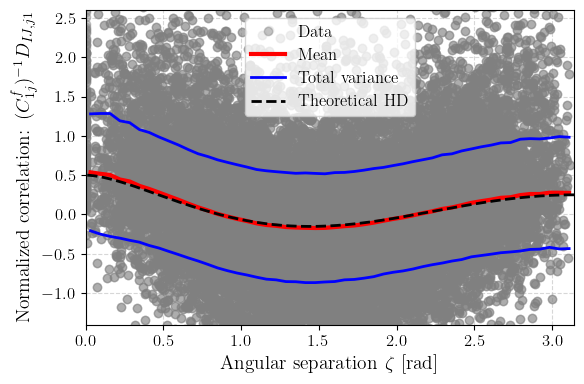

In [ ]:
plt.figure(figsize=(6, 4))

# Scatter plot of raw data
plt.plot(
    x_all[0].flatten(),
    y_all[0].flatten(),
    "o",
    alpha=0.4,
    color="gray",
    label=r"Data",
)

y_all = y_all[x_all > 1e-4]
x_all = x_all[x_all > 1e-4]


# Compute binned statistics
n_bins = 50
bin_means, bin_std, bin_centers = ut.compute_D_IJ_mean(
    x_all.flatten(), y_all.flatten(), n_bins
)

# Plot mean
plt.plot(
    bin_centers,
    bin_means,
    color="red",
    linewidth=3,
    label=r"Mean",
)

# Plot mean ± std
plt.plot(
    bin_centers,
    bin_means + bin_std,
    color="blue",
    linewidth=2,
    # linestyle="--",
    label=r"Total variance",
)
plt.plot(
    bin_centers,
    bin_means - bin_std,
    color="blue",
    linewidth=2,
    # linestyle="--",
)

# Plot theoretical curve
plt.plot(
    np.arccos(gt.x),
    gt.HD_correlations(gt.x),
    color="black",
    linestyle="dashed",
    linewidth=2,
    label=r"Theoretical HD",
)

# Axes labels with LaTeX
plt.xlabel(r"Angular separation $\zeta$ [rad]", fontsize=14)
plt.ylabel(
    r"Normalized correlation: $(C^f_{1j})^{-1}D_{IJ,j1}$",
    fontsize=14,
)

# Set limits
plt.xlim(0, np.pi)
plt.ylim(-1.4, 2.6)

# Add legend
plt.legend(fontsize=12, loc="best")

# Grid and layout
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Optional: show or save
plt.savefig("plots/CIJ_tot.pdf")
plt.show()

### - Data simulation to compute correlation cosmic variance and compare to the theoretical prediction

In [ ]:
# Number of pulsars and realizations
npulsars = 200
n_realizations = 100

# For simplicity redefine the spectrum to be flat
# (this way it needs much less realizations)
H_p_ff = Pk[:, None] * S_ff[None, :] ** 0

# Compute frequency-domain normalization matrix for D_IJ
C_ff = dc.get_D_IJ_fifj_normalization(Tspan, fi, ff, H_p_ff)

# Compute inverse of C_ff for normalization purposes
inv_ff = ut.compute_inverse(C_ff)


# Lists to store angular separations and normalized D_IJ for all realizations
x_pulsar_average = []
y_pulsar_average = []
x_all = []
y_all = []

# Loop over independent realizations
for realization in tqdm.tqdm(range(n_realizations)):

    # Generate angular separation and data correlation matrix
    _, zeta_IJ, D_IJ_ij = gd.generate_D_IJ_fifj(
        Nside, npulsars, Tspan, fi, ff, H_p_ff
    )

    # Normalize D_IJ by multiplying with inverse of C_ff along frequency indices
    C_normed = jnp.einsum("fg,glab->flab", inv_ff, D_IJ_ij)

    # Select a specific frequency pair (i,j) to store
    i = 1
    j = 1

    # Store angular separations and corresponding normalized D_IJ for this frequency pair
    x_all.append(zeta_IJ)
    y_all.append(C_normed[i, j])

# Convert lists to arrays for further analysis
x_all = jnp.array(x_all)  # Shape: (n_realizations, npulsars, npulsars)
y_all = jnp.array(y_all)  # Shape: (n_realizations, ff_size, ff_size)


# Compute pulsar average over n_bins
n_bins = 50
x_avg_iso, y_avg_iso = ut.compute_pulsar_average_D_IJ(x_all, y_all, n_bins)

x_pulsar_average = jnp.array(x_avg_iso)
y_pulsar_average = jnp.array(y_avg_iso)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


### - Final plot

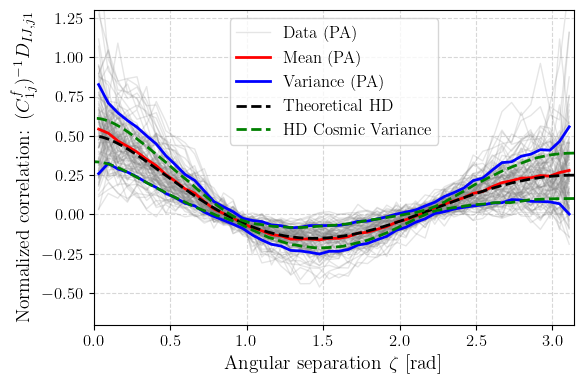

In [ ]:
# Start figure
plt.figure(figsize=(6, 4))

# Plot individual realizations (light grey for visualizing scatter)
for i in range(n_realizations):
    if i == 0:
        plt.plot(
            x_pulsar_average[i],
            y_pulsar_average[i],
            linewidth=1,
            alpha=0.2,
            color="grey",
            label=r"Data (PA)",
        )
    else:
        plt.plot(
            x_pulsar_average[i],
            y_pulsar_average[i],
            linewidth=1,
            color="grey",
            alpha=0.2,
        )

# Plot mean across all realizations
plt.plot(
    x_pulsar_average[0],
    np.mean(y_pulsar_average, axis=0),
    "red",
    label=r"Mean (PA)",
    linewidth=2,
)

# Plot ±1σ (standard deviation) bands around the mean
plt.plot(
    x_pulsar_average[0],
    np.mean(y_pulsar_average, axis=0) + np.std(y_pulsar_average, axis=0),
    "blue",
    label=r"Variance (PA)",
    linewidth=2,
)
plt.plot(
    x_pulsar_average[0],
    np.mean(y_pulsar_average, axis=0) - np.std(y_pulsar_average, axis=0),
    "blue",
    linewidth=2,
)

# Overlay theoretical Hellings–Downs curve
plt.plot(
    np.arccos(gt.x),
    gt.HD_correlations(gt.x),
    "black",
    linestyle="dashed",
    linewidth=2,
    label=r"Theoretical HD",
)

# Overlay cosmic variance quantiles (green dashed lines)
plt.plot(
    np.arccos(x_HDplot),
    quantiles_HDplot[0],
    "--",
    alpha=1,
    linewidth=2,
    color="green",
    label=r"HD Cosmic Variance",
)
plt.plot(
    np.arccos(x_HDplot),
    quantiles_HDplot[2],
    "--",
    alpha=1,
    linewidth=2,
    color="green",
)

# Set axes limits, labels, legend, grid, and layout
plt.xlim(0, np.pi)
plt.ylim(-0.7, 1.3)
plt.xlabel(r"Angular separation $\zeta$ [rad]", fontsize=14)
plt.ylabel(
    r"Normalized correlation: $(C^f_{1j})^{-1}D_{IJ,j1}$",
    fontsize=14,
)
plt.legend(fontsize=12, loc="best")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Save figure
plt.savefig("plots/CIJ_pulsar_average.pdf")
plt.show()